<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Notebook comparing diaSources from preconvolution+filtering vs template convolution</b> <br>
Contact author: Ian Sullivan<br>
Last verified to run: 28 July 2023<br>
LSST Science Piplines version: w_2023_34<br>
Run with a local ap_verify run of ap_verify_ci_hits2015


## Run details

Baseline run in comparison with pre-convolution

* Used weekly `w_2023_34`
* Also branch tickets/DM-39976 of `ip_diffim` for preconvolution with filtering
* Run locally, not on USDF



# pipeline .yaml for ap_verify with template convolution
```
description: Instrumented Alert Production pipeline specialized for CI-HiTS-2015
imports:
  - location: $AP_VERIFY_DIR/pipelines/DarkEnergyCamera/ApVerify.yaml
parameters:
  # Use dataset's specific templates
  coaddName: goodSeeing
tasks:
  isr:
    class: lsst.ip.isr.IsrTask
    config:
      # This dataset contains CP calibs, not regular ones
      connections.bias: cpBias
      connections.flat: cpFlat
  calibrate:
    class: lsst.pipe.tasks.calibrate.CalibrateTask
    config:
      # Use dataset's reference catalogs
      file: $AP_VERIFY_CI_HITS2015_DIR/config/calibrate.py
  subtractImages:
    class: lsst.ip.diffim.subtractImages.AlardLuptonSubtractTask
    config:
      connections.coaddName: parameters.coaddName
      doApplyFinalizedPsf: False
  detectAndMeasure:
    class: lsst.ip.diffim.detectAndMeasure.DetectAndMeasureTask
    config:
      connections.coaddName: parameters.coaddName
      doSkySources: True
  diaPipe:
    class: lsst.ap.association.DiaPipelineTask
    config:
      doSolarSystemAssociation: true
  transformDiaSrcCat:
    class: lsst.ap.association.TransformDiaSourceCatalogTask
    config:
      doIncludeReliability: True
```

# pipeline .yaml for ap_verify with preconvolution
```
description: Instrumented Alert Production pipeline specialized for CI-HiTS-2015

imports:
  - location: $AP_VERIFY_DIR/pipelines/DarkEnergyCamera/ApVerify.yaml
parameters:
  # Use dataset's specific templates
  coaddName: goodSeeing
tasks:
  isr:
    class: lsst.ip.isr.IsrTask
    config:
      # This dataset contains CP calibs, not regular ones
      connections.bias: cpBias
      connections.flat: cpFlat
  calibrate:
    class: lsst.pipe.tasks.calibrate.CalibrateTask
    config:
      # Use dataset's reference catalogs
      file: $AP_VERIFY_CI_HITS2015_DIR/config/calibrate.py
  subtractImages:
    class: lsst.ip.diffim.subtractImages.AlardLuptonSubtractTask
    config:
      connections.coaddName: parameters.coaddName
      doApplyFinalizedPsf: False
  detectAndMeasure:
    class: lsst.ip.diffim.detectAndMeasure.DetectAndMeasureScoreTask
    config:
      connections.coaddName: parameters.coaddName
      doSkySources: True
  subtractScoreImages:
    class: lsst.ip.diffim.subtractImages.AlardLuptonPreconvolveSubtractTask
    config:
      connections.coaddName: parameters.coaddName
      doApplyFinalizedPsf: False
  diaPipe:
    class: lsst.ap.association.DiaPipelineTask
    config:
      doSolarSystemAssociation: true
  transformDiaSrcCat:
    class: lsst.ap.association.TransformDiaSourceCatalogTask
    config:
      doIncludeReliability: True
```

### 1. Main package imports

In [1]:
import os
import importlib
import pprint

In [2]:
import matplotlib.pyplot as plt
#%matplotlib widget
%matplotlib inline

import numpy as np
import pandas as pd

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [4]:
import lsst.afw.display as afwDisplay
import lsst.geom

import lsst.daf.butler as dafButler
import lsst.pipe.base

In [5]:
!setup -r ../../build/analysis_ap -j

In [6]:
!eups list analysis_ap

   LOCAL:/Users/sullivan/LSST/code/build/analysis_ap 	setup


In [7]:
from lsst.analysis.ap import apdb

In [101]:
from lsst.analysis.ap import legacyApdbUtils as utils
from lsst.analysis.ap import legacyPlotUtils as plac
from lsst.analysis.ap import nb_utils

In [9]:
from astropy.table import Table

In [10]:
importlib.reload(plac)

<module 'lsst.analysis.ap.legacyPlotUtils' from '/Users/sullivan/LSST/code/build/analysis_ap/python/lsst/analysis/ap/legacyPlotUtils.py'>

In [11]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

importlib.reload(utils)

<module 'lsst.analysis.ap.legacyApdbUtils' from '/Users/sullivan/LSST/code/build/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py'>

### 2. Data access config
We are comparing multiple runs now, so we have to define where to find the data and the APDBs for each run.

#### Keys for default run.

In [12]:
repo = '/Users/sullivan/LSST/code/ap_verify_output/w_2023_34/repo/'
collections = 'ap_verify-output'
instrument = 'DECam'
skymap = 'decam_rings_v1'

butler = dafButler.Butler(repo, collections=collections)

dbType='sqlite'
dbName="/Users/sullivan/LSST/code/ap_verify_output/w_2023_34/association.db"

reader = apdb.ApdbSqliteQuery(dbName, butler=butler, instrument='DECam')

In [13]:
len(reader._tables)

9

In [14]:
default_run = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [15]:
default_run['run_name'] = 'Default'

#### This set is for preconvolution using the code from `w_2023_34`

In [16]:
repo = '/Users/sullivan/LSST/code/ap_verify_output/w_2023_34_preconvolution/repo/'
collections = 'ap_verify-output'
instrument = 'DECam'
skymap = 'decam_rings_v1'

butler = dafButler.Butler(repo, collections=collections)

dbType='sqlite'
dbName="/Users/sullivan/LSST/code/ap_verify_output/w_2023_34_preconvolution/association.db"

reader = apdb.ApdbSqliteQuery(dbName, butler=butler, instrument='DECam')

In [17]:
preconv0_run = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [18]:
preconv0_run['run_name'] = 'Base with pre-convolution'

#### This set is for pre-convolution using the code from the branch `tickets/DM-39976` of `ip_diffim`

In [19]:
repo = '/Users/sullivan/LSST/code/ap_verify_output/tickets/DM-39976/preconvolution/repo/'
collections = 'ap_verify-output'
instrument = 'DECam'
skymap = 'decam_rings_v1'

butler = dafButler.Butler(repo, collections=collections)

dbType='sqlite'
dbName="/Users/sullivan/LSST/code/ap_verify_output/tickets/DM-39976/preconvolution/association.db"

reader = apdb.ApdbSqliteQuery(dbName, butler=butler, instrument='DECam')

In [20]:
preconv_run = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [21]:
preconv_run['run_name'] = 'Pre-convolution'

## A. Analysis of Sources

### 3. Number of detections
Now loading the tables to compare among them

In [25]:
default_run['robjTable'] = default_run['reader'].load_objects()
default_run['rsrcTable'] = default_run['reader'].load_sources()

In [28]:
preconv0_run['robjTable'] = preconv0_run['reader'].load_objects()
preconv0_run['rsrcTable'] = preconv0_run['reader'].load_sources()

In [26]:
preconv_run['robjTable'] = preconv_run['reader'].load_objects()
preconv_run['rsrcTable'] = preconv_run['reader'].load_sources()

Look at how many objects and sources we picked right from the reader

In [30]:
n_objs = pd.DataFrame()

In [31]:
n_objs.loc['default', 'n_rdiasrc'] = len(default_run['rsrcTable'])
n_objs.loc['preconv0', 'n_rdiasrc'] = len(preconv0_run['rsrcTable'])
n_objs.loc['preconv', 'n_rdiasrc'] = len(preconv_run['rsrcTable'])

In [32]:
n_objs.loc['default', 'n_rdiaobj'] = len(default_run['robjTable'])
n_objs.loc['preconv0', 'n_rdiaobj'] = len(preconv0_run['robjTable'])
n_objs.loc['preconv', 'n_rdiaobj'] = len(preconv_run['robjTable'])

In [33]:
n_objs

,n_rdiasrc,n_rdiaobj
default,1178.0,991.0
preconv0,1204.0,1041.0
preconv,911.0,751.0


In [34]:
test_table2 = preconv_run['reader'].load_sources()

In [35]:
object_columns = ['diaObjectId', 'ra', 'dec', 'nDiaSources', 'g_psfFluxMean', 
                  'r_psfFluxMean', 'i_psfFluxMean', 'z_psfFluxMean', 'y_psfFluxMean',
                  'validityEnd', 'flags']

In [36]:
source_columns = ['diaSourceId', 'diaObjectId', 'ra', 'dec', 'ccdVisitId', 'midpointMjdTai',
                  'apFlux', 'psfFlux', 'apFluxErr', 'psfFluxErr', 'scienceFlux', 'scienceFluxErr',
                  'snr', 'x', 'y', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'flags', 'reliability', 'band',
                  'visit', 'detector', 'instrument']

In [37]:
table1 = default_run['robjTable'][default_run['robjTable'].validityEnd.isnull()]

Inspect the columns of the object table

In [125]:
for c in table1.columns:
    print(c)

diaObjectId
validityStart
validityEnd
ra
raErr
dec
decErr
ra_dec_Cov
radecMjdTai
pmRa
pmRaErr
pmDec
pmDecErr
parallax
parallaxErr
pmRa_pmDec_Cov
pmRa_parallax_Cov
pmDec_parallax_Cov
pmParallaxLnL
pmParallaxChi2
pmParallaxNdata
u_psfFluxMean
u_psfFluxMeanErr
u_psfFluxSigma
u_psfFluxChi2
u_psfFluxNdata
u_fpFluxMean
u_fpFluxMeanErr
u_fpFluxSigma
g_psfFluxMean
g_psfFluxMeanErr
g_psfFluxSigma
g_psfFluxChi2
g_psfFluxNdata
g_fpFluxMean
g_fpFluxMeanErr
g_fpFluxSigma
r_psfFluxMean
r_psfFluxMeanErr
r_psfFluxSigma
r_psfFluxChi2
r_psfFluxNdata
r_fpFluxMean
r_fpFluxMeanErr
r_fpFluxSigma
i_psfFluxMean
i_psfFluxMeanErr
i_psfFluxSigma
i_psfFluxChi2
i_psfFluxNdata
i_fpFluxMean
i_fpFluxMeanErr
i_fpFluxSigma
z_psfFluxMean
z_psfFluxMeanErr
z_psfFluxSigma
z_psfFluxChi2
z_psfFluxNdata
z_fpFluxMean
z_fpFluxMeanErr
z_fpFluxSigma
y_psfFluxMean
y_psfFluxMeanErr
y_psfFluxSigma
y_psfFluxChi2
y_psfFluxNdata
y_fpFluxMean
y_fpFluxMeanErr
y_fpFluxSigma
u_lcPeriodic
g_lcPeriodic
r_lcPeriodic
i_lcPeriodic
z_lcPeriodic


Inspect the columns of the source table

In [38]:
table2 = default_run['rsrcTable']

In [40]:
for c in table2.columns:
    print(c)

diaSourceId
ccdVisitId
diaObjectId
ssObjectId
parentDiaSourceId
ssObjectReassocTime
midpointMjdTai
ra
raErr
dec
decErr
ra_dec_Cov
x
xErr
y
yErr
x_y_Cov
apFlux
apFluxErr
snr
psfFlux
psfFluxErr
psfRa
psfRaErr
psfDec
psfDecErr
psfFlux_psfRa_Cov
psfFlux_psfDec_Cov
psfRa_psfDec_Cov
psfLnL
psfChi2
psfNdata
trailFlux
trailFluxErr
trailRa
trailRaErr
trailDec
trailDecErr
trailLength
trailLengthErr
trailAngle
trailAngleErr
trailFlux_trailRa_Cov
trailFlux_trailDec_Cov
trailFlux_trailLength_Cov
trailFlux_trailAngle_Cov
trailRa_trailDec_Cov
trailRa_trailLength_Cov
trailRa_trailAngle_Cov
trailDec_trailLength_Cov
trailDec_trailAngle_Cov
trailLength_trailAngle_Cov
trailLnL
trailChi2
trailNdata
dipoleMeanFlux
dipoleMeanFluxErr
dipoleFluxDiff
dipoleFluxDiffErr
dipoleRa
dipoleRaErr
dipoleDec
dipoleDecErr
dipoleLength
dipoleLengthErr
dipoleAngle
dipoleAngleErr
dipoleMeanFlux_dipoleFluxDiff_Cov
dipoleMeanFlux_dipoleRa_Cov
dipoleMeanFlux_dipoleDec_Cov
dipoleMeanFlux_dipoleLength_Cov
dipoleMeanFlux_dipoleAng

In [41]:
ccdVisitIds = set(table2['ccdVisitId'])

In [152]:
ccdVisitIds

{41137156, 41137160, 41142005, 41142010, 41980205, 41980210}

Now filter the objects which are not valid and pick the useful columns.

In [42]:
default_run['objTable'] = default_run['robjTable'][default_run['robjTable'].validityEnd.isnull()][object_columns]
preconv_run['objTable'] = preconv_run['robjTable'][preconv_run['robjTable'].validityEnd.isnull()][object_columns]
preconv0_run['objTable'] = preconv0_run['robjTable'][preconv0_run['robjTable'].validityEnd.isnull()][object_columns]

In [43]:
default_run['srcTable'] = default_run['rsrcTable'][source_columns]
preconv0_run['srcTable'] = preconv0_run['rsrcTable'][source_columns]
preconv_run['srcTable'] = preconv_run['rsrcTable'][source_columns]

Check numbers once more

In [44]:
n_objs.loc['default', 'n_diasrc'] = len(default_run['srcTable'])
n_objs.loc['preconv0', 'n_diasrc'] = len(preconv0_run['srcTable'])
n_objs.loc['preconv', 'n_diasrc'] = len(preconv_run['srcTable'])

In [45]:
n_objs.loc['default', 'n_diaobj'] = len(default_run['objTable'])
n_objs.loc['preconv0', 'n_diaobj'] = len(preconv0_run['objTable'])
n_objs.loc['preconv', 'n_diaobj'] = len(preconv_run['objTable'])

In [46]:
n_objs

,n_rdiasrc,n_rdiaobj,n_diasrc,n_diaobj
default,1178.0,991.0,1178.0,991.0
preconv0,1204.0,1041.0,1204.0,1041.0
preconv,911.0,751.0,911.0,751.0


Note that no objects were filtered out by the above check

### 4. Flags 
Loading up the flag tables now

In [47]:
badFlagList = [
    'base_PixelFlags_flag_bad',
    'base_PixelFlags_flag_suspect',
    'base_PixelFlags_flag_saturatedCenter',
    'base_PixelFlags_flag_interpolated',
    'base_PixelFlags_flag_interpolatedCenter',
    'base_PixelFlags_flag_edge'
    ]

In [48]:
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig

In [49]:
import functools
import operator

In [50]:
config = TransformDiaSourceCatalogConfig()
unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')

In [51]:
def add_flag_tables(run_dict, badFlagList):
    """
    Unpack the flags and add the resulting tables to the run dictionary
    """
    run_dict['flagValues'] = unpacker.unpack(run_dict['srcTable']['flags'], 'flags')
    run_dict['flagTable'] = pd.DataFrame(run_dict['flagValues'], index=run_dict['srcTable'].index)

    run_dict['srcTableFlags'] = pd.merge(run_dict['srcTable'], run_dict['flagTable'], left_index=True, right_index=True)
    
    badFlags = [run_dict['srcTableFlags'][flag] for flag in badFlagList]
    flagFilter = functools.reduce(operator.or_, badFlags)
    noFlagFilter = ~flagFilter

    run_dict['goodSrc'] = run_dict['srcTableFlags'].loc[noFlagFilter]

    run_dict['goodObjIds'] = set(run_dict['srcTableFlags'].loc[noFlagFilter, 'diaObjectId'])

    run_dict['goodObj'] = run_dict['objTable'].loc[run_dict['objTable']['diaObjectId'].isin(run_dict['goodObjIds'])]
    
    return flagFilter, noFlagFilter

In [52]:
flagFilter, noFlagFilter = add_flag_tables(default_run, badFlagList)
flagFilter0, noFlagFilter0 = add_flag_tables(preconv0_run, badFlagList)
flagFilter1, noFlagFilter1 = add_flag_tables(preconv_run, badFlagList)

In [53]:
n_objs.loc['default', 'n_good_diaobj'] = len(default_run['goodObj'])
n_objs.loc['preconv0', 'n_good_diaobj'] = len(preconv0_run['goodObj'])
n_objs.loc['preconv', 'n_good_diaobj'] = len(preconv_run['goodObj'])

In [54]:
n_objs.loc['default', 'n_good_diasrc'] = len(default_run['goodSrc'])
n_objs.loc['preconv0', 'n_good_diasrc'] = len(preconv0_run['goodSrc'])
n_objs.loc['preconv', 'n_good_diasrc'] = len(preconv_run['goodSrc'])

In [55]:
n_objs

,n_rdiasrc,n_rdiaobj,n_diasrc,n_diaobj,n_good_diaobj,n_good_diasrc
default,1178.0,991.0,1178.0,991.0,428.0,560.0
preconv0,1204.0,1041.0,1204.0,1041.0,406.0,507.0
preconv,911.0,751.0,911.0,751.0,411.0,511.0


Text(0, 0.5, 'N')

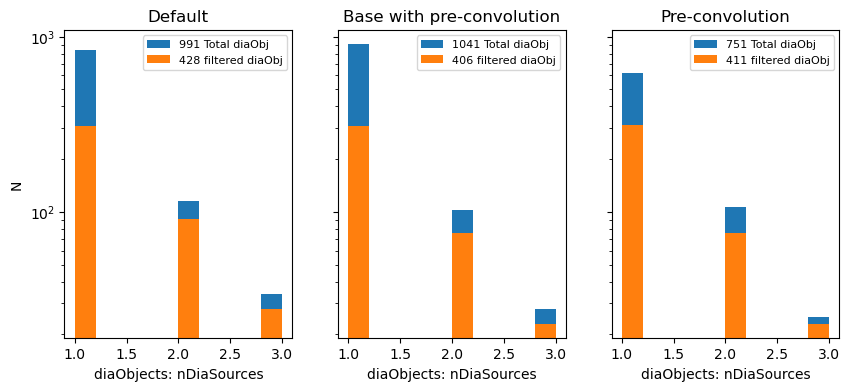

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
for i_run, run_dict in enumerate([default_run, preconv0_run, preconv_run]):
    #plt.figure(figsize=(12, 8))
    ax = axes.flatten()[i_run]

    ax.hist(run_dict['objTable'].nDiaSources, log=True, label=f"{len(run_dict['objTable'])} Total diaObj")
    #plt.xlabel('diaObjects: nDiaSources')
    #plt.legend(loc='best')

    ax.hist(run_dict['goodObj'].nDiaSources, log=True, label=f"{len(run_dict['goodObj'])} filtered diaObj")
    ax.set_xlabel('diaObjects: nDiaSources')
    ax.legend(loc='best', fontsize=8)
    ax.set_title(run_dict['run_name'])
axes.flatten()[0].set_ylabel('N')

Small differences in good objects, a moderate difference in the total number of objects

## 4.1 Real-bogus reliability scores

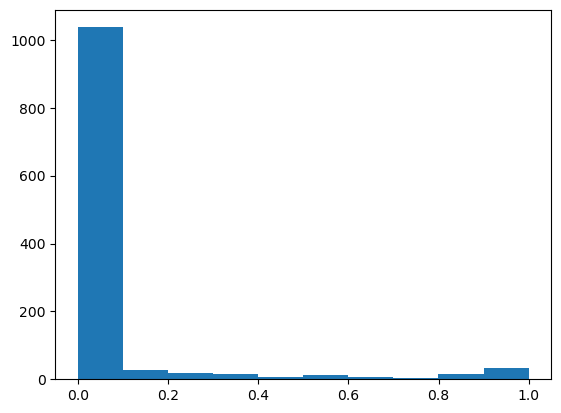

In [63]:
default_hist = plt.hist(default_run['srcTable']['reliability'])

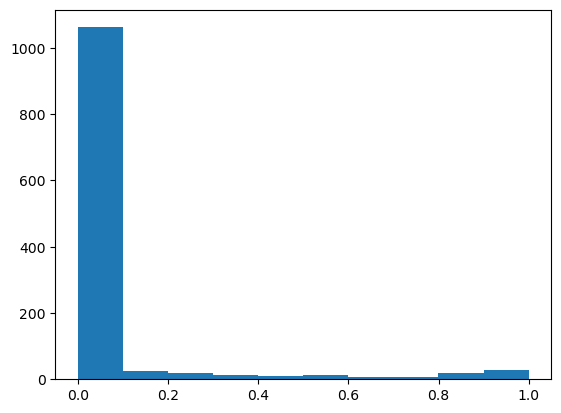

In [64]:
preconv0_hist = plt.hist(preconv0_run['srcTable']['reliability'])

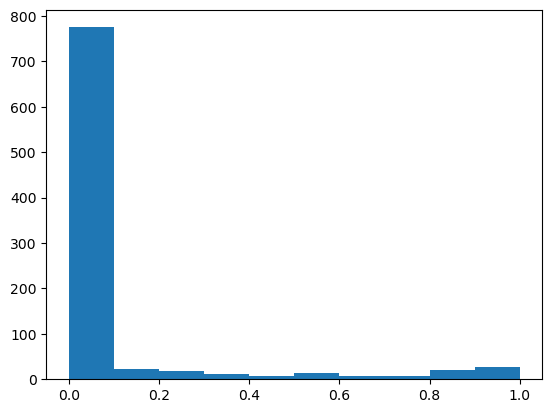

In [65]:
preconv_hist = plt.hist(preconv_run['srcTable']['reliability'])

In [84]:
reliability_table = pd.DataFrame()

In [89]:
reliability_table['reliability'] = np.around(default_hist[1][:-1], 3)

In [87]:
reliability_table[default_run['run_name']] = default_hist[0]
reliability_table[preconv0_run['run_name']] = preconv0_hist[0]
reliability_table[preconv_run['run_name']] = preconv_hist[0]

In [90]:
reliability_table

,reliability,Default,Base with pre-convolution,Pre-convolution
0,0.0,1037.0,1062.0,775.0
1,0.1,28.0,26.0,23.0
2,0.2,18.0,18.0,18.0
3,0.3,16.0,13.0,12.0
4,0.4,6.0,10.0,8.0
5,0.5,13.0,14.0,13.0
6,0.6,7.0,7.0,7.0
7,0.7,4.0,8.0,8.0
8,0.8,15.0,18.0,20.0
9,0.9,34.0,28.0,27.0


In [110]:
print(default_hist[1][5])
print(np.sum(default_hist[0][5:]))
print(np.sum(preconv0_hist[0][5:]))
print(np.sum(preconv_hist[0][5:]))

0.49991050574964335
73.0
75.0
75.0


From the above table, there is a small change in the total number of diaSources with "good" reliability (above 0.5) between the pipeline default and using preconvolution, and negligible differences between the new and old implementation of preconvolution. The significant change is with the number of diaSources with the worst reliability scores, indicating that the new version of preconvolution is eliminating spurious detections.

### Repeat with only good sources

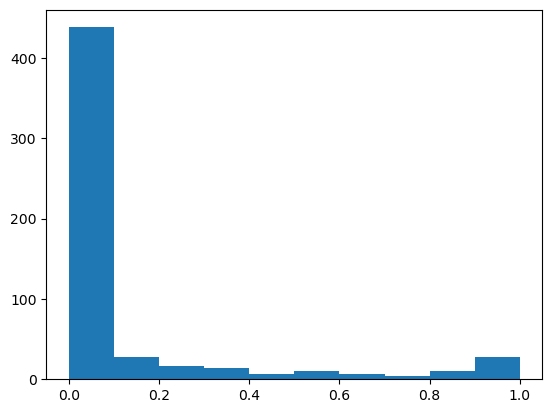

In [111]:
default_hist = plt.hist(default_run['goodSrc']['reliability'])

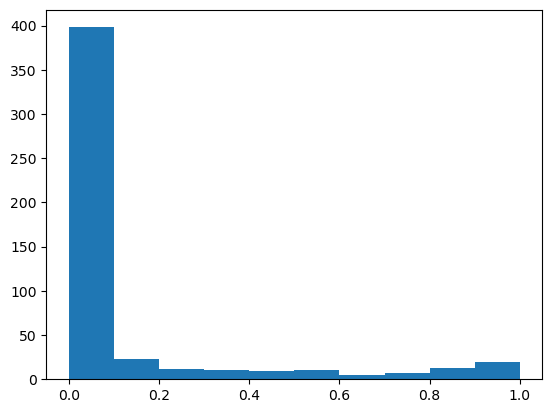

In [112]:
preconv0_hist = plt.hist(preconv0_run['goodSrc']['reliability'])

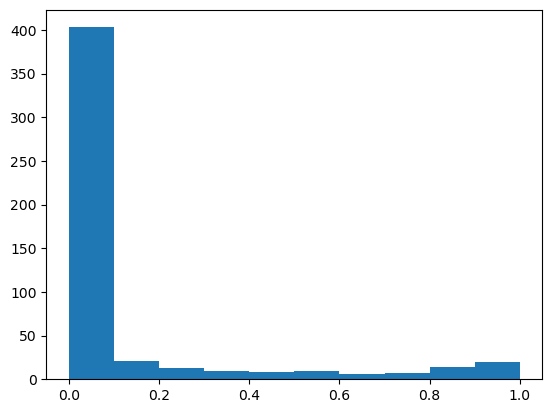

In [113]:
preconv_hist = plt.hist(preconv_run['goodSrc']['reliability'])

In [114]:
reliability_table = pd.DataFrame()

In [115]:
reliability_table['reliability'] = np.around(default_hist[1][:-1], 3)

In [116]:
reliability_table[default_run['run_name']] = default_hist[0]
reliability_table[preconv0_run['run_name']] = preconv0_hist[0]
reliability_table[preconv_run['run_name']] = preconv_hist[0]

In [117]:
reliability_table

,reliability,Default,Base with pre-convolution,Pre-convolution
0,0.0,438.0,398.0,403.0
1,0.1,28.0,23.0,21.0
2,0.2,16.0,12.0,13.0
3,0.3,14.0,10.0,9.0
4,0.4,6.0,9.0,8.0
5,0.5,10.0,11.0,10.0
6,0.6,6.0,5.0,6.0
7,0.7,4.0,7.0,7.0
8,0.8,10.0,13.0,14.0
9,0.9,28.0,19.0,20.0


In [118]:
print(default_hist[1][5])
print(np.sum(default_hist[0][5:]))
print(np.sum(preconv0_hist[0][5:]))
print(np.sum(preconv_hist[0][5:]))

0.49991061426739236
58.0
55.0
57.0


There is much less of a difference seen between the objects that are flagged as "good". 

## 5. Sky plots on sources

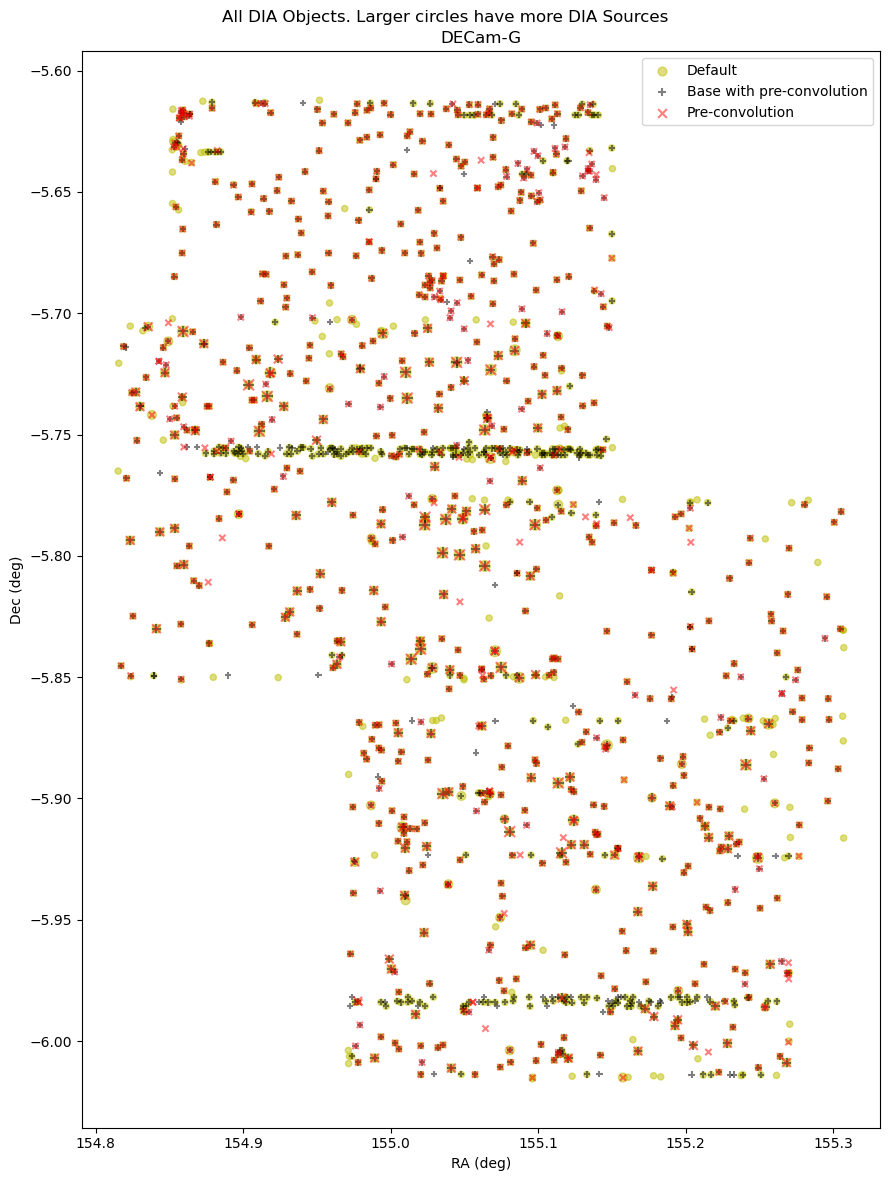

In [179]:
nSrc = 0  # threshold for which DIA Objects to plot (only those with > nSrc constituent DIA Sources)

fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('All DIA Objects. Larger circles have more DIA Sources')

for i_run, run_dict in enumerate([default_run, preconv0_run, preconv_run]):

#     xlim = [149.7, 149.5]
#     ylim = [2.7, 2.9]
    #plt.setp(axs, xlim=xlim, ylim=ylim)
    
    goodFilter = (run_dict['objTable']['nDiaSources'] > nSrc)
#     goodFilter = run_dict[]
    
#     axG = axs[i_run]
    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('DECam-G')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']

    ax.scatter(run_dict['objTable'].loc[goodFilter, 'ra'],
               run_dict['objTable'].loc[goodFilter, 'dec'],
               s=run_dict['objTable'].loc[goodFilter, 'nDiaSources']*20, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

In [123]:
table_test = run_dict['goodObj']

In [124]:
table_test.columns

Index(['diaObjectId', 'ra', 'dec', 'nDiaSources', 'g_psfFluxMean',
       'r_psfFluxMean', 'i_psfFluxMean', 'z_psfFluxMean', 'y_psfFluxMean',
       'validityEnd', 'flags'],
      dtype='object')

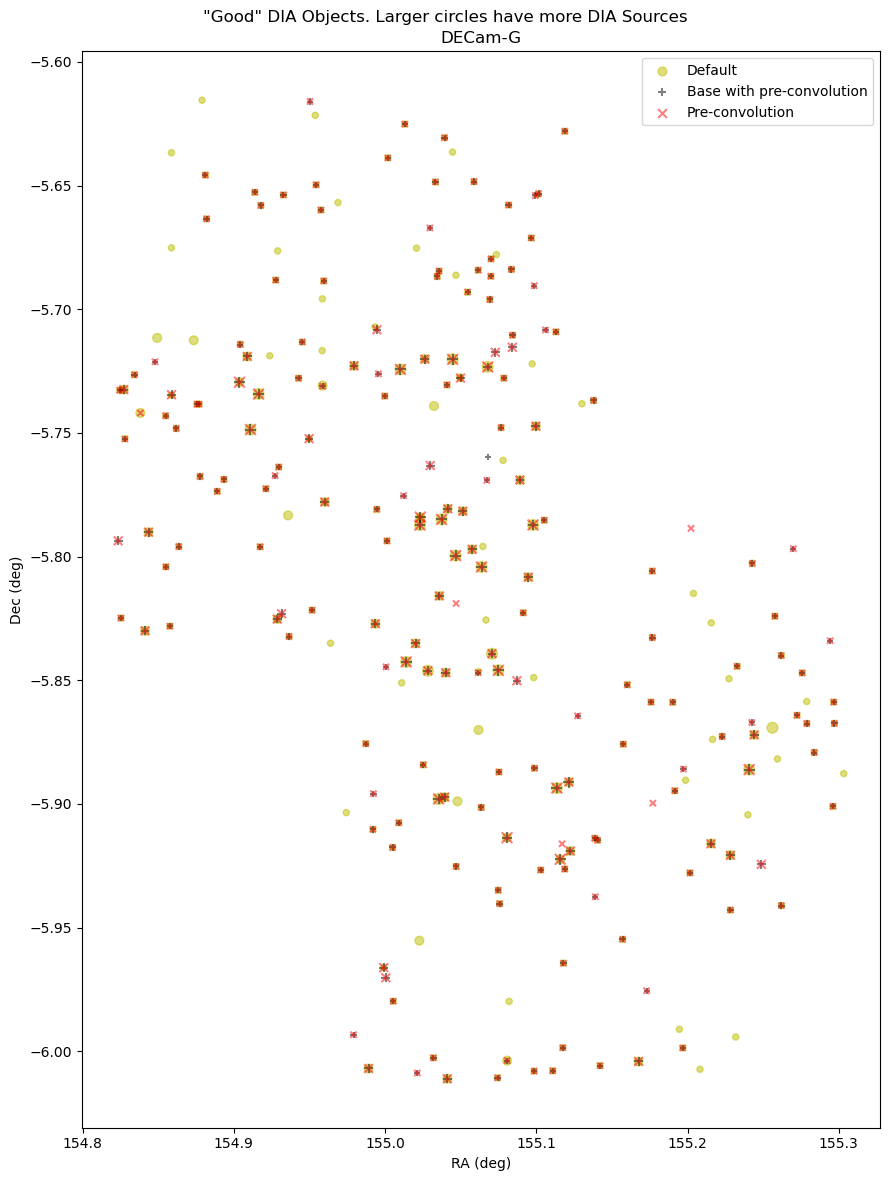

In [180]:
nSrc = 0  # threshold for which DIA Objects to plot (only those with > nSrc constituent DIA Sources)

fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('"Good" DIA Objects. Larger circles have more DIA Sources')

for i_run, run_dict in enumerate([default_run, preconv0_run, preconv_run]):

#     xlim = [149.7, 149.5]
#     ylim = [2.7, 2.9]
    #plt.setp(axs, xlim=xlim, ylim=ylim)
    
    goodFilter = (run_dict['goodObj']['nDiaSources'] > nSrc) &\
                 (run_dict['goodObj']['g_psfFluxMean'] > 0)
#     goodFilter = run_dict[]
    
#     axG = axs[i_run]
    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('DECam-G')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']

    ax.scatter(run_dict['goodObj'].loc[goodFilter, 'ra'],
               run_dict['goodObj'].loc[goodFilter, 'dec'],
               s=run_dict['goodObj'].loc[goodFilter, 'nDiaSources']*20, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

There are few differences between the old and new implementations of preconvolution when looking at all of the "good" diaObjects, with any number of diaSources. There are no differences between the two runs when restricting to only "good" diaObjects with more than one diaSource.

## 4.2 Comparison of diaSources between runs

In [98]:
objectTable1 = default_run['goodObj']
objectTable1b = preconv0_run['goodObj']
objectTable2 = preconv_run['goodObj']

In [99]:
objectTable1.columns

Index(['diaObjectId', 'ra', 'dec', 'nDiaSources', 'g_psfFluxMean',
       'r_psfFluxMean', 'i_psfFluxMean', 'z_psfFluxMean', 'y_psfFluxMean',
       'validityEnd', 'flags'],
      dtype='object')

In [102]:
obj_default, obj_preconv, obj_match = nb_utils.compareDB(default_run['repo'], preconv_run['repo'],
                                                         default_run['collections'], preconv_run['collections'],
                                                         default_run['reader'], preconv_run['reader'],
                                                         matchRadius=0.2, displayCutouts=False,
                                                         badFlagList=badFlagList,
                                                         cutoutPath='/Users/sullivan/LSST/code/ap_verify_output/tickets/DM-39976/cutouts')

308 matched sources; 252 unique to set 1; 204 unique to set 2.


492 matched sources; 15 unique to set 1; 20 unique to set 2.
Unique to dataset 1: 88341378425159998


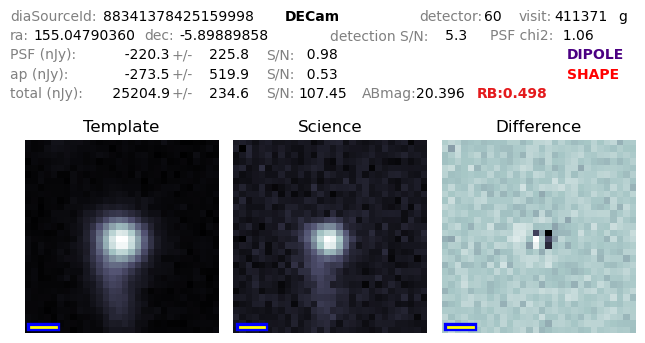

Unique to dataset 1: 88341378425160011


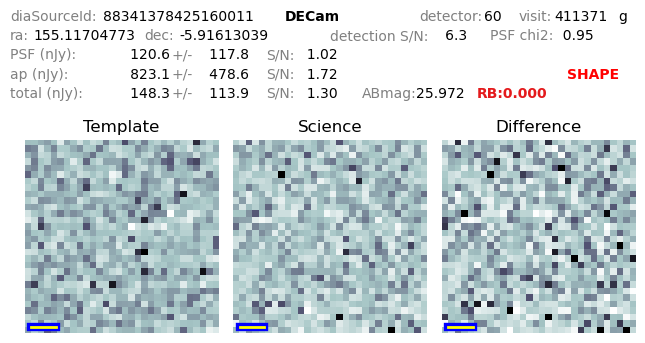

Unique to dataset 1: 88341378425160037


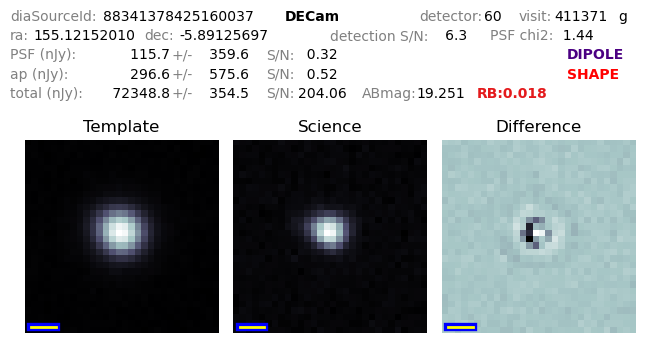

Unique to dataset 1: 88341378425160068


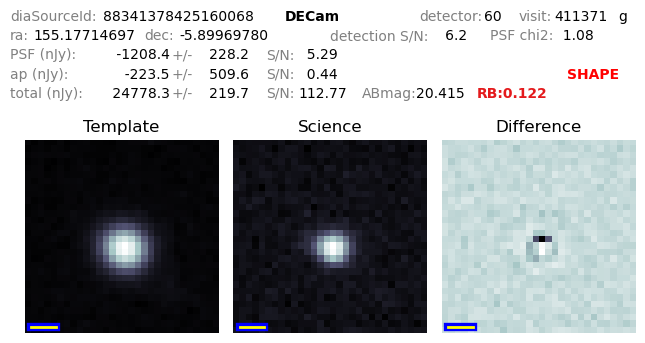

Unique to dataset 1: 88341378425160073


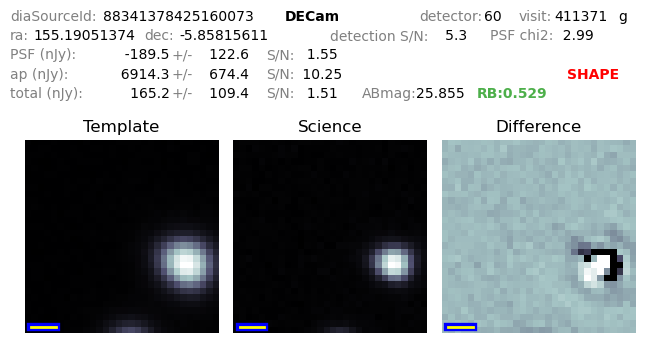

Unique to dataset 1: 88341378425160115


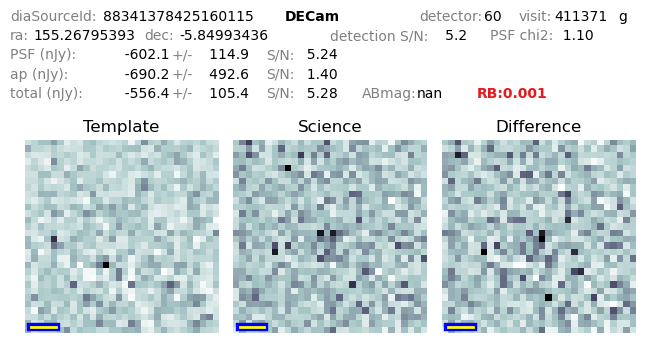

Unique to dataset 1: 88351793720852885


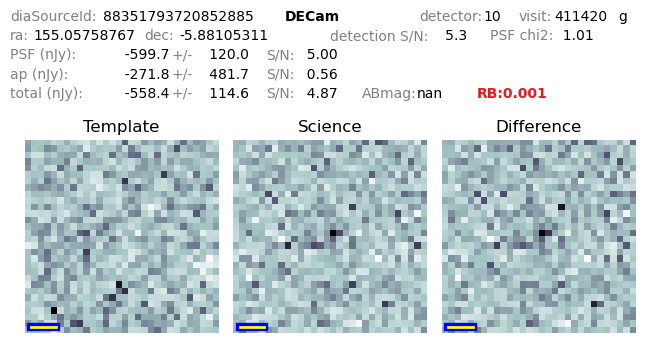

Unique to dataset 1: 88351793720852904


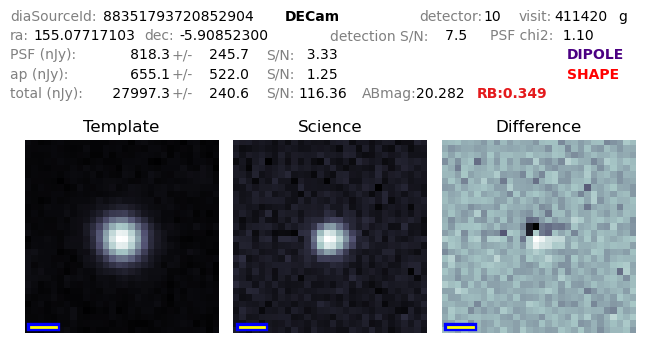

Unique to dataset 1: 88341369835225708


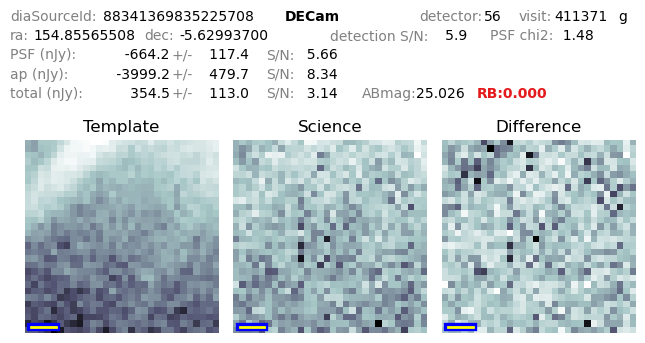

Unique to dataset 1: 88341369835225864


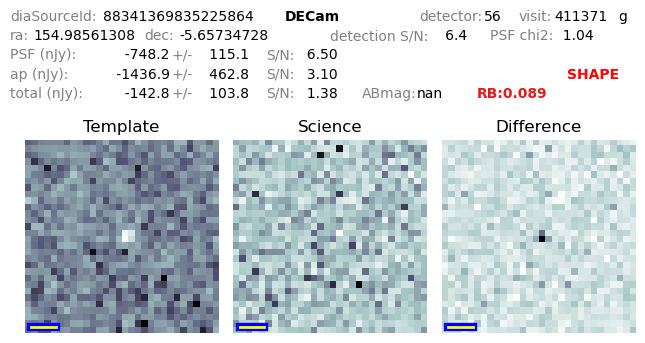

Unique to dataset 1: 88341369835225936


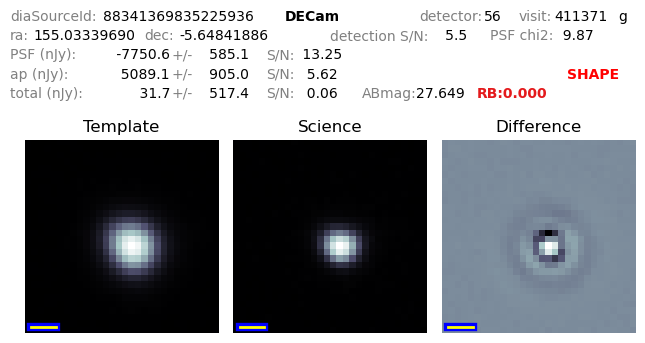

Unique to dataset 1: 88341369835225944


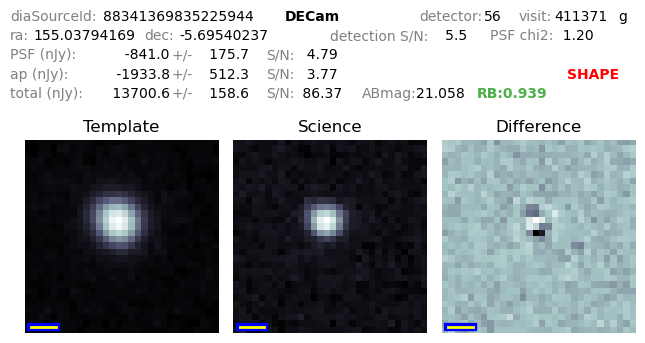

Unique to dataset 1: 88341369835225999


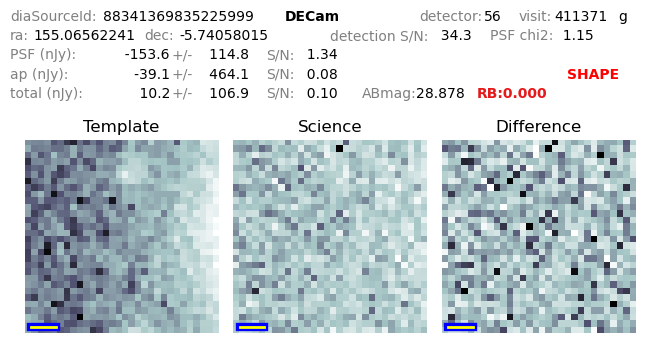

Unique to dataset 1: 88351782983434532


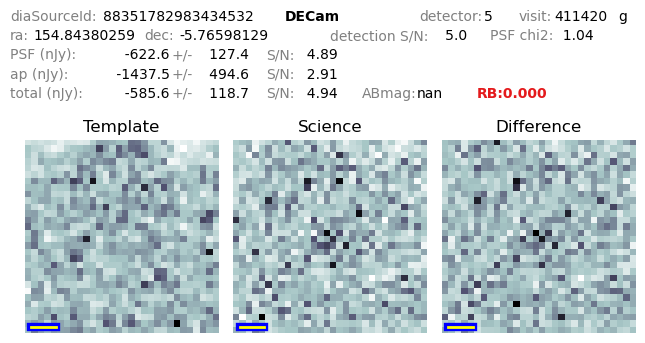

Unique to dataset 1: 88351782983434550


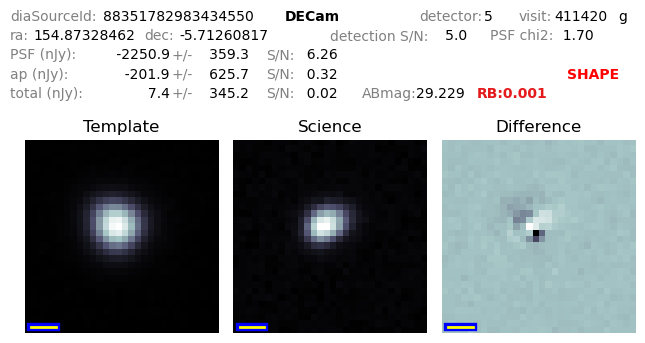

Unique to dataset 2: 88341378425159980


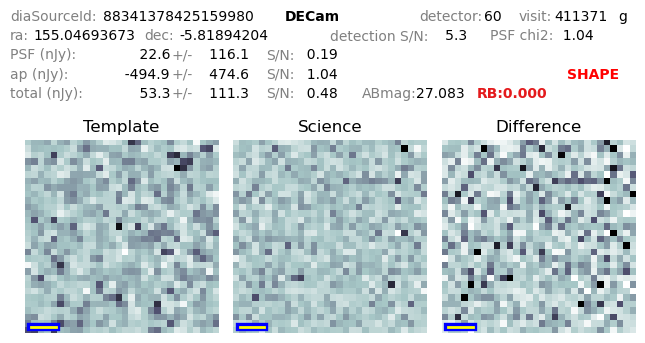

Unique to dataset 2: 88341378425159990


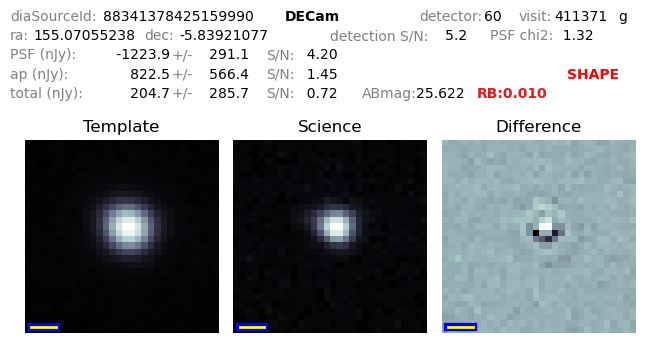

Unique to dataset 2: 88341378425159999


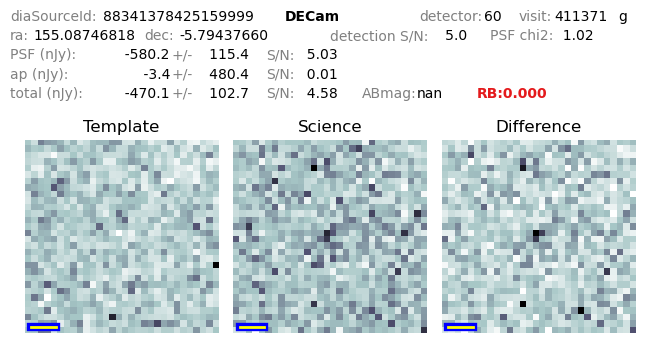

Unique to dataset 2: 88341378425160011


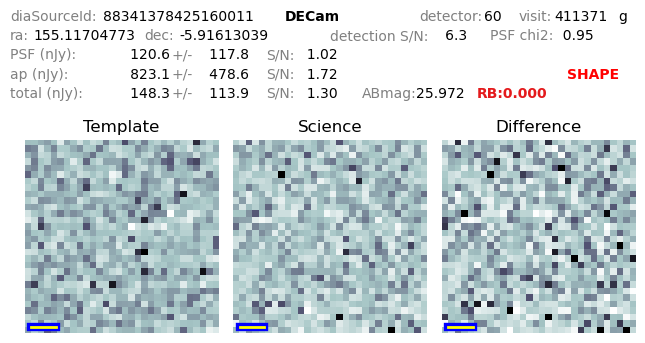

Unique to dataset 2: 88341378425160032


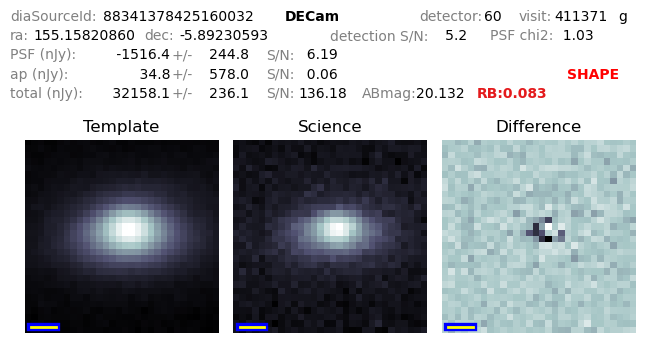

Unique to dataset 2: 88341378425160041


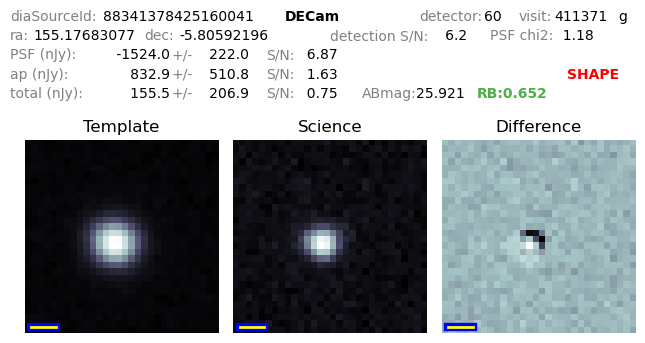

Unique to dataset 2: 88341378425160046


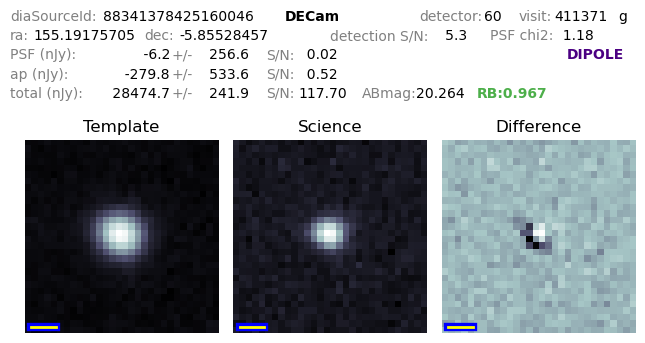

Unique to dataset 2: 88341378425160051


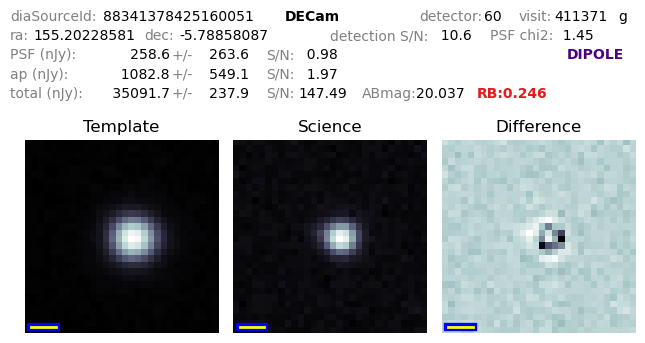

Unique to dataset 2: 88341378425160055


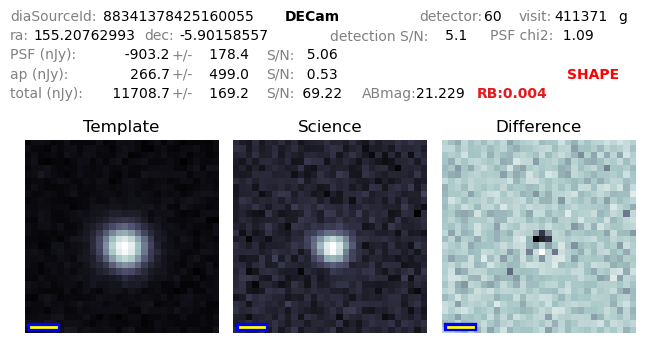

Unique to dataset 2: 88341378425160081


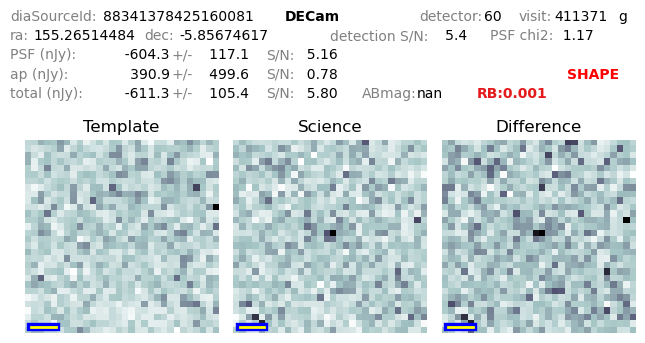

Unique to dataset 2: 88351793720852793


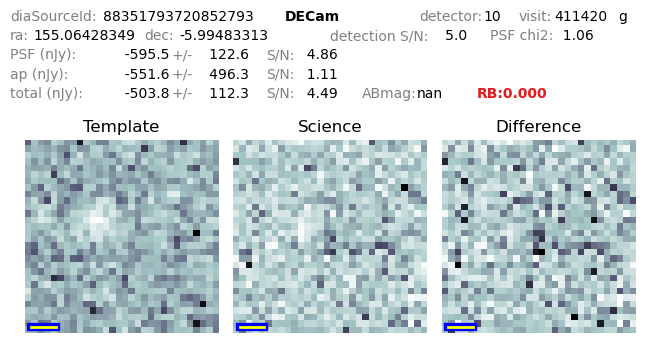

Unique to dataset 2: 88351793720852803


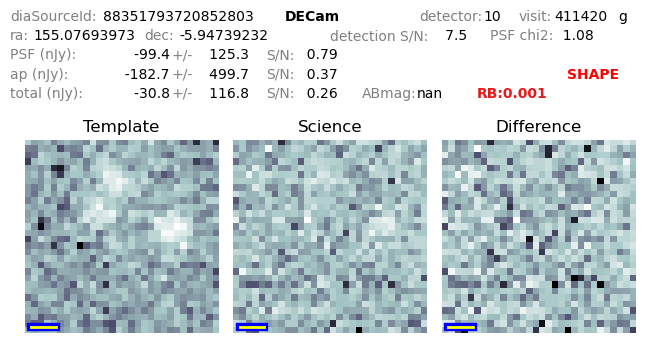

Unique to dataset 2: 88341369835225597


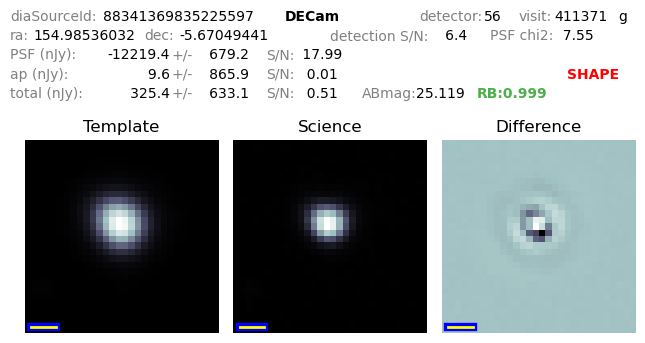

Unique to dataset 2: 88341369835225649


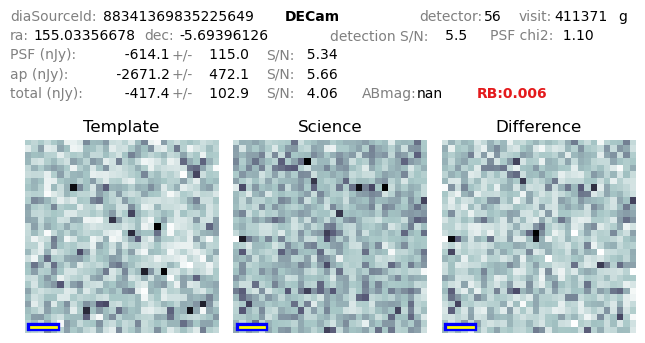

Unique to dataset 2: 88341369835225655


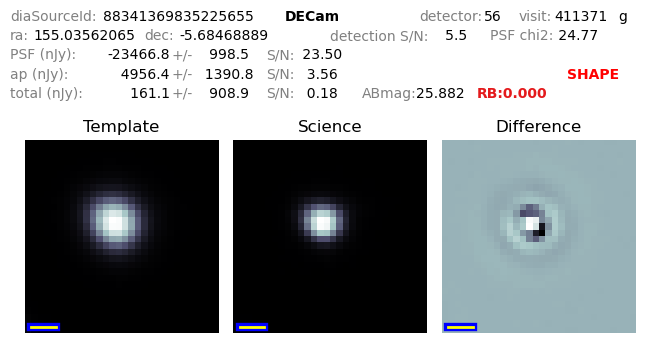

Unique to dataset 2: 88341369835225689


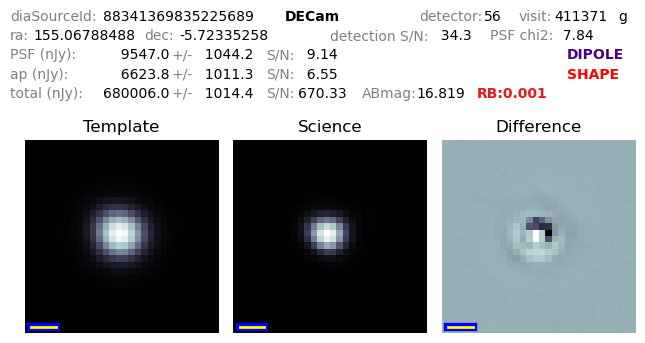

Unique to dataset 2: 88351782983434510


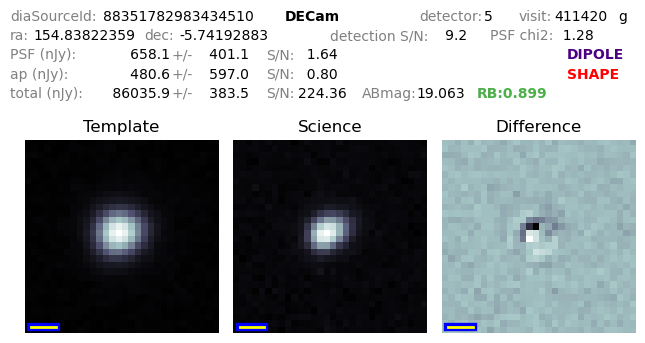

Unique to dataset 2: 88351782983434512


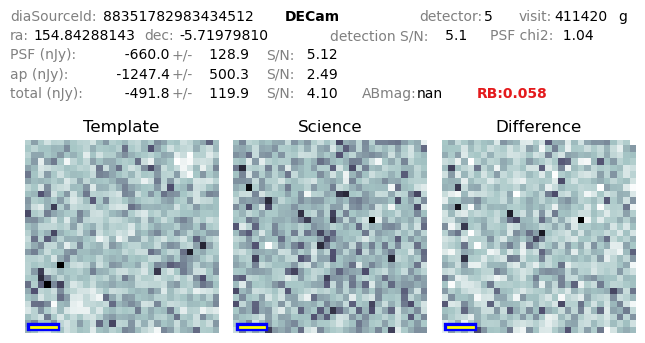

Unique to dataset 2: 88351782983434533


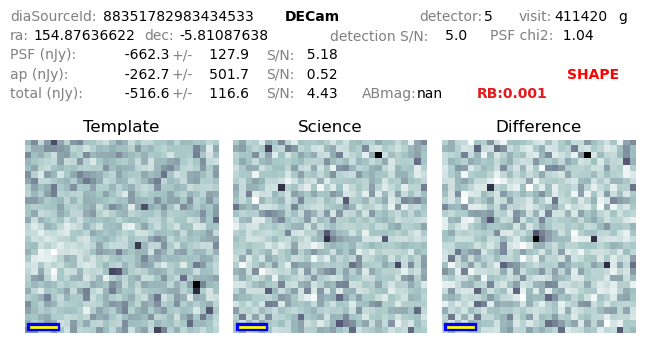

Unique to dataset 2: 88351782983434628


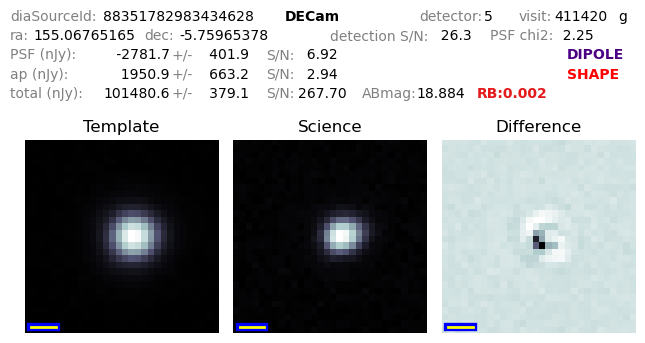

In [105]:
obj_preconv0, obj_preconv1, obj_match1 = nb_utils.compareDB(preconv0_run['repo'], preconv_run['repo'],
                                                            preconv0_run['collections'], preconv_run['collections'],
                                                            preconv0_run['reader'], preconv_run['reader'],
                                                            matchRadius=0.2, displayCutouts=True,
                                                            badFlagList=badFlagList,
                                                            cutoutPath='/Users/sullivan/LSST/code/ap_verify_output/tickets/DM-39976/cutouts_preconvolution')

In [87]:
highObs_default = obj_default.diaSourceId[obj_default['reliability'] > 0.1]

In [88]:
highObs_preconv = obj_preconv.diaSourceId[obj_preconv['reliability'] > 0.1]

In [89]:
len(highObs_default)

65

In [90]:
len(highObs_preconv)

49

## 6. Cutouts

### 7. Flag frequency analysis

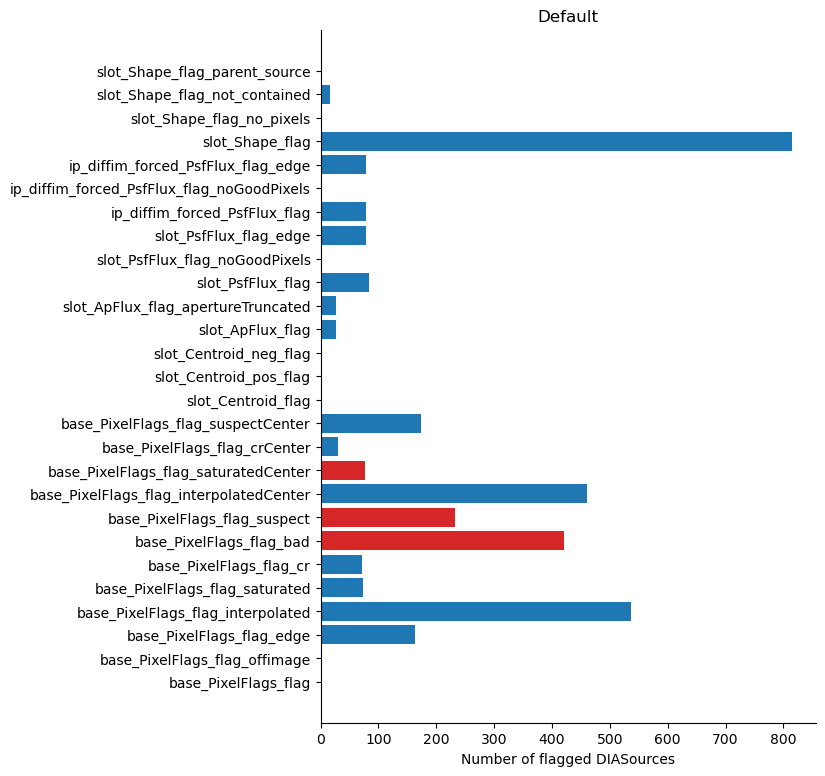

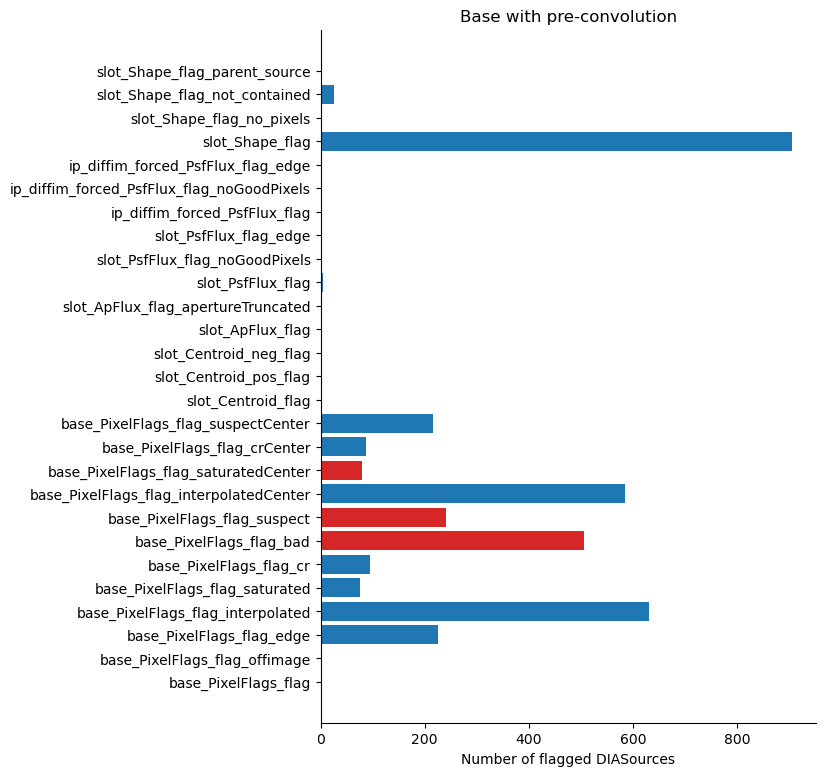

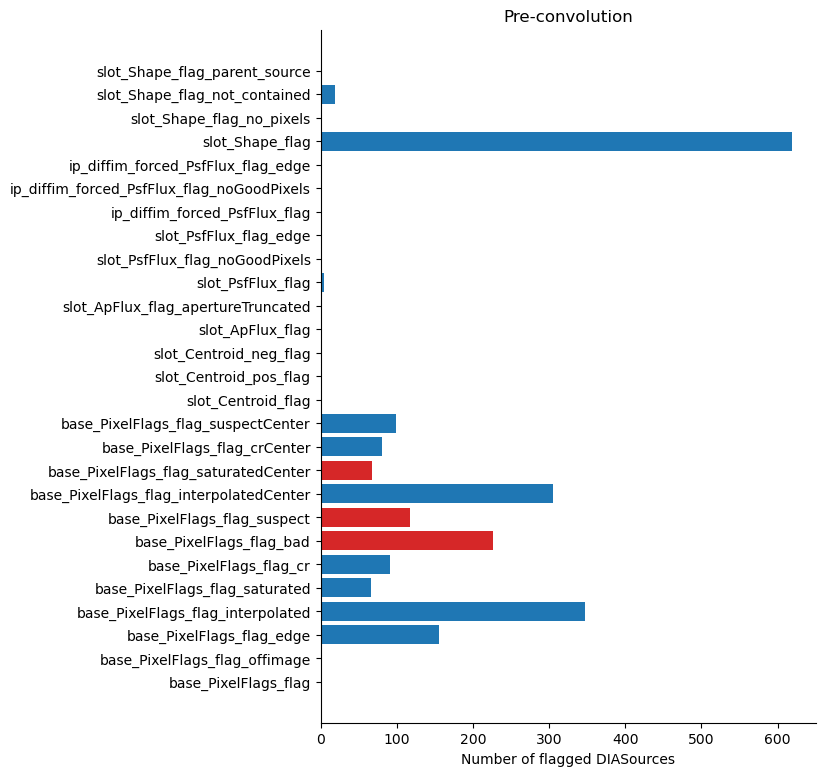

In [106]:
for arun in [default_run, preconv0_run, preconv_run]:
    repo = arun['repo']
    goodSrc = arun['goodSrc']
    collections = arun['collections']
    srcTable = arun['srcTable']
    
    plac.plotFlagHist(srcTable, title=f'{arun["run_name"]}')

### 8. diaSource reliability score

Not really part of this ticket, but since we have all the sources available let's compare diaSource reliability scores from real-bogus between runs.

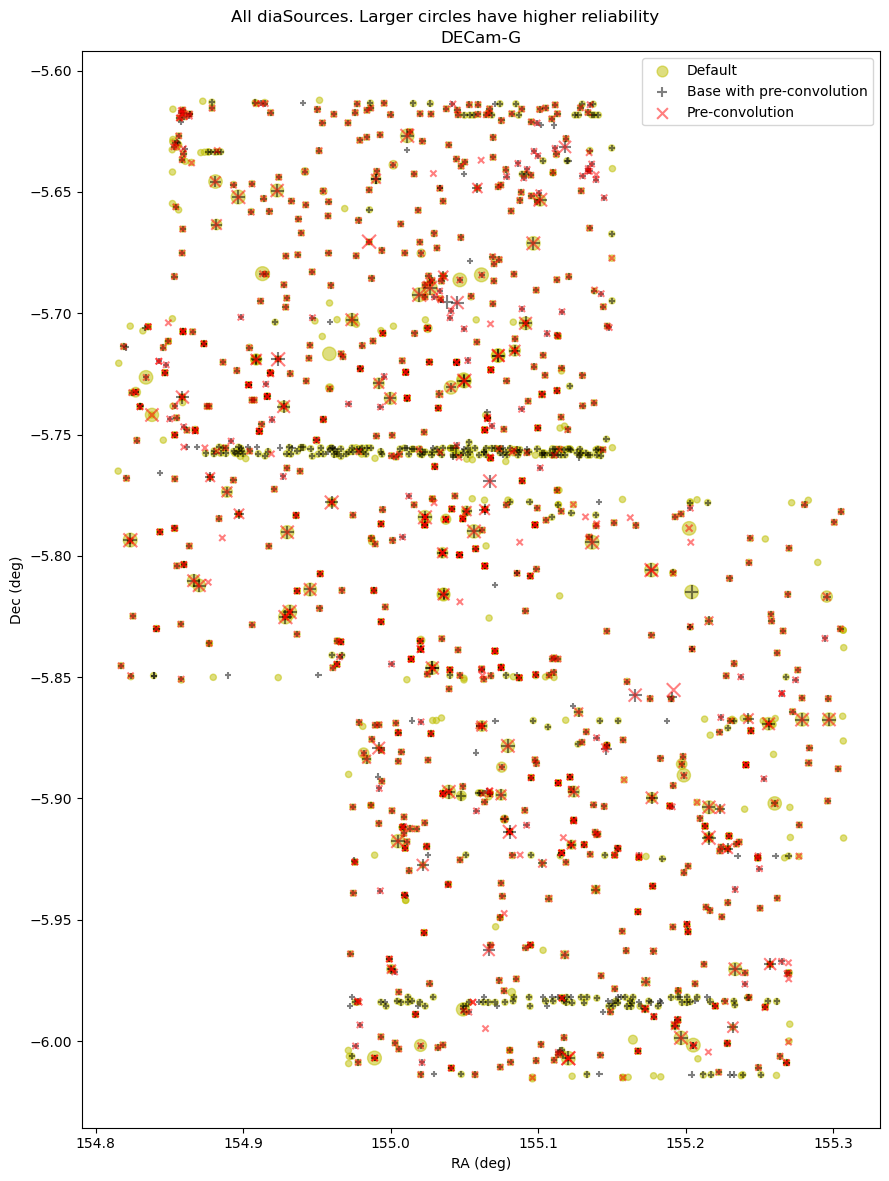

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('All diaSources. Larger circles have higher reliability')

for i_run, run_dict in enumerate([default_run, preconv0_run, preconv_run]):

    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('DECam-G')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']
    sizes = run_dict['srcTable']['reliability']*100
    sizes = [max([s, 20]) for s in sizes]

    ax.scatter(run_dict['srcTable']['ra'],
               run_dict['srcTable']['dec'],
               s=sizes, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

A few observations on the above scores:
* The streaks of clearly bad sources in the default and the previous version of preconvolution all have minimal reliability.
* In general, there is strong agreement between different runs for sources with high reliability
* However, some high scoring sources appear only in some runs and not others. These merit future investigation.
* Strangely, some sources detected in multiple versions have different reliability scores. This is strange because the real-bogus classifier uses only the source location, the unmodified science image, the warped (but not PSF-matched) template, and the template-convolved difference image. The difference image should be identically the same in each of these cases, since preconvolution generates the maximum liklihood image in addition to the standard template-convolved difference image. The only difference between the runs for scoring should be the source location.

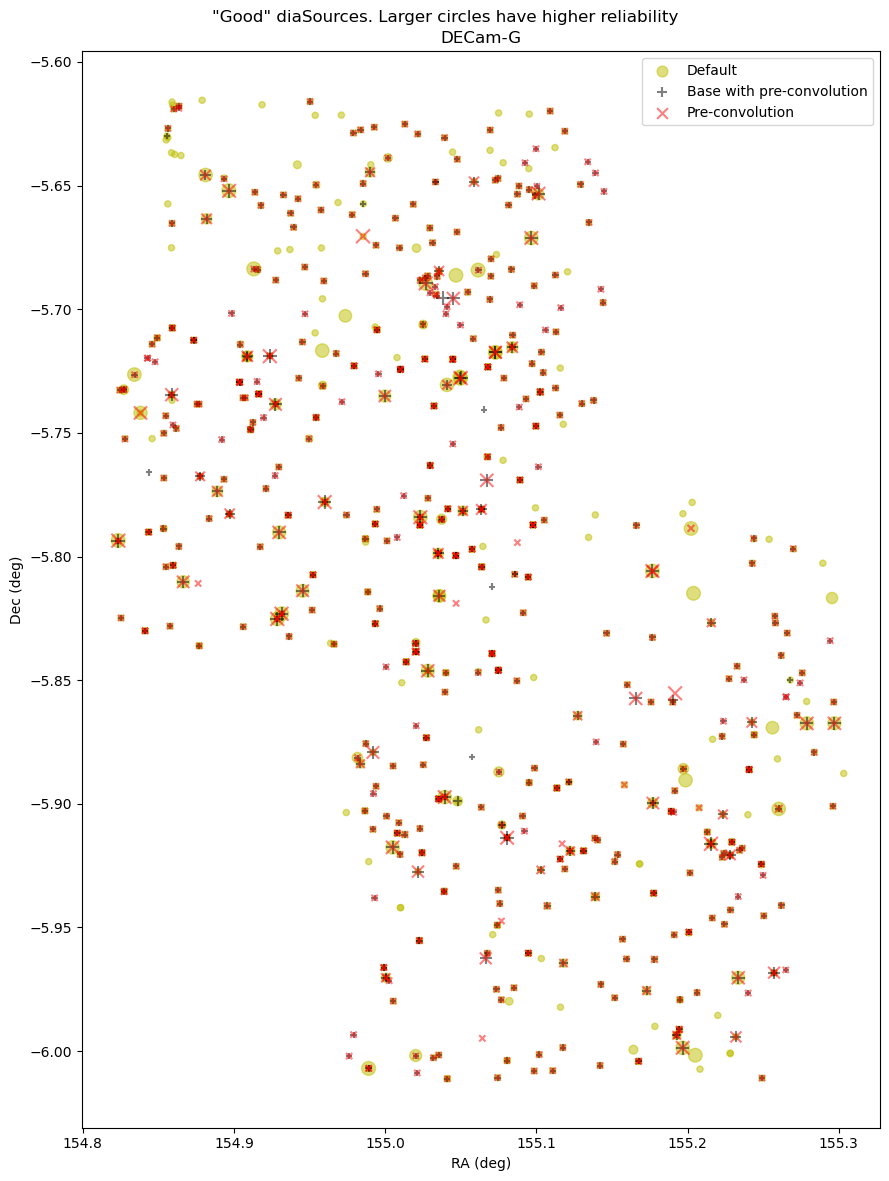

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('"Good" diaSources. Larger circles have higher reliability')

for i_run, run_dict in enumerate([default_run, preconv0_run, preconv_run]):

    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('DECam-G')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']
    sizes = run_dict['goodSrc']['reliability']*100
    sizes = [max([s, 20]) for s in sizes]

    ax.scatter(run_dict['goodSrc']['ra'],
               run_dict['goodSrc']['dec'],
               s=sizes, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

A few observations on the above scores of "good" diaSources
* In general, the agreement between runs appears excellent.
* There are noticeably more "good" sources detected with the standard template-convolved difference image than with preconvolution.
* There are *more* high reliability diaSources that are missing matched sources. From a quick visual comparison to the previous figure, it is clear that several of these sources do have matches, but they are flagged.